# Scoring the graphs with the gene ontology

## Prerequisites

You will need [Biopython](https://biopython.org/) in order to parse the gene ontology file. It should be part of the [anaconda](https://www.anaconda.com/) distribution. 

You will also need `networkx`, which is also a standard library of the anaconda distribution.

## Loading the gene ontology.

Here, we map the ensembl ID of genes to their GO terms.

In [33]:
from Bio.UniProt.GOA import gafiterator
import gzip
import pandas as pd
import networkx as nx
from copy import deepcopy

# Load the annotations, map them to their respective protein coding gene
filename = './DataPreparation/goa_human.gaf.gz'
fp = gzip.open(filename, 'rt')
gafi = gafiterator(fp)
gene_to_go = {}
go_to_desc = {}

# Create a dictionnary mapping gene symbols to their GO terms
for i in gafi:
    gene = i['DB_Object_Symbol']
    go_id = i['GO_ID']
    if gene not in gene_to_go:
        gene_to_go[gene] = []
    gene_to_go[gene].append(go_id)
    
# Load the mapping from ensemble genes to gene symbols
ens_to_gene = pd.read_csv("./DataPreparation/gene_name_mapping.csv")
ens_to_gene.set_index("V2", inplace=True)

# Map ensembl IDs to their Go terms.
ens_to_go = {}
for gene in ens_to_gene.index:
        if gene in gene_to_go:
                go_ids = gene_to_go[gene]
        else:
                continue
        ens = ens_to_gene.loc[gene,'V1']
        if isinstance(ens, pd.Series):
                ens = ens.iloc[0]
        ens_to_go[ens] = go_ids

ens_genes = ens_to_go.keys()

## Code to score one graph

See the appendix of [this paper](https://www.tandfonline.com/doi/full/10.1080/01621459.2018.1434531) for more details on this enrichment metric.

In [25]:
# This is the function that scores one graph, once it has been annotated.
def score_graph(g):
    N1_T = {}
    N2_T = {}
    for e in g.edges(data=True):
        source = e[0]
        target = e[1]
        s1 = g.node[source]['a']
        s2 = g.node[target]['a']
        intersection = s1 & s2
        if len(intersection) == 0:
            continue
        for term in intersection:
            if term not in N1_T:
                N1_T[term] = 0
            N1_T[term] += 1.0
    for source in g.nodes():
        if len(g.node[source]['a']) == 0:
            continue
        source_ann = g.node[source]['a']
        for term in source_ann:
            if term not in N2_T:
                N2_T[term] = 0
            N2_T[term] += 1
    Ne = len(g.edges())
    Nn = len(g.nodes())
    r = (Nn**2 - Nn) / Ne

    scores = []
    st = {}
    for term in N2_T:
        if term not in N1_T:
            scores.append(0)
            st[term] = 0
            continue
        scores.append(N1_T[term] * 1.0 / (N2_T[term]**2 - N2_T[term]))
        st[term] = scores[-1]
    avg = np.mean(scores)
    if avg == 0:
        return st, 1e-08

    return st, avg * r

In [90]:
# Prepare empty graphs with annotations
# This creates a graph with no edges but with one node/gene.
# Sets of GO terms are attached to the nodes

def create_empty_graph(tissue):
    valid_genes = pd.read_csv("./DataPreparation/valid_genes_per_tissue/" + tissue + '.csv')
    nms = valid_genes.x
    G = nx.Graph()
    for i, nm in enumerate(nms):
        if nm not in ens_to_go:
            continue
        G.add_node(i)
        G.node[i]['name'] = nm
        G.node[i]['a'] = set(ens_to_go[nm])
    return G

## Scoring the graphs

Finally, we can assign a score to each graph. If you have run the R notebook `EstimationWithRSVP.ipynb` before, you should have a directory called `results` with one .csv file per tissue. 

In [112]:
from glob import glob
import numpy as np
files = glob("results/*.csv")
enrichment_scores = {}
for fn in files:
    tissue = '_'.join(fn.split('/')[-1].split('_')[:-2])
    print(tissue)
    path = pd.read_csv(fn)
    path.columns = ['gene_name', 'row', 'col', 'value']
    # Create an emtpy graph for that tissue
    G = create_empty_graph(tissue)
    for i in range(path.shape[0]):
        # Add the ith edge and score
        n1 = path.iloc[i,1] - 1 #Subtract one because Python is 0 indexed
        n2 = path.iloc[i,2] - 1
        a1 = G.node[n1]['a'] # The annotations for that node
        a2 = G.node[n2]['a']
        G.add_edge(n1,n2,a=a1&a1) # Add the edge and annotate it with the intersection of the nodes' annotations.

        G2 = deepcopy(G)
        st, s = score_graph(G2)
        enrichment_scores[('Estimated Graph', tissue, i+1)] = s 
        
    # Let us add a graph which connects edges at random
    # to see how ti compares
    G = create_empty_graph(tissue)
    n_nodes = len(G.nodes)
    for i in range(path.shape[0]):
        # Add the ith edge and score
        n1 = np.random.randint(low=1, high=n_nodes) - 1 #Subtract one because Python is 0 indexed
        n2 = np.random.randint(low=1, high=n_nodes) - 1
        a1 = G.node[n1]['a'] # The annotations for that node
        a2 = G.node[n2]['a']
        G.add_edge(n1,n2,a=a1&a1) # Add the edge and annotate it with the intersection of the nodes' annotations.

        G2 = deepcopy(G)
        st, s = score_graph(G2)
        enrichment_scores[('Random Graph', tissue, i+1)] = s 

Adipose_Visceral_Omentum
Adipose_Subcutaneous


Populating the interactive namespace from numpy and matplotlib


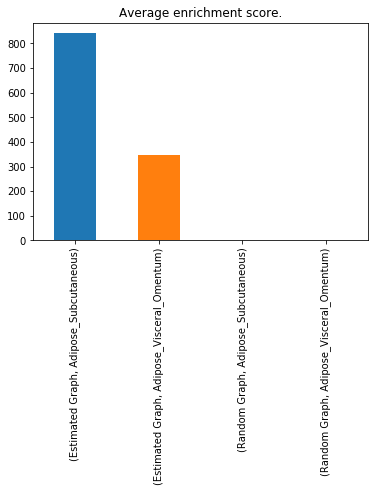

In [123]:
%pylab inline
pd.Series(enrichment_scores).unstack().T.mean().plot.bar(title='Average enrichment score.')